# County-to-county Inflow Migration

### Documentation for network analysis on inflow migrations

### Sections
1. Import modules needed
2. Data preprocessing
3. Filtering individual states after getting total node and edge lists
4. Network and community visualizations for states
5. Conclusion

### Main Goals

* Redo Ohio county inflow graph in Python
* Create reproduceable code that makes inflow community graphs for every state
* Later on: look at longer distance moves, so maybe going to counties from other states


# Section 1: Import Modules Needed

In [411]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pylab
from cdlib import algorithms,viz
from matplotlib import colormaps

# Section 2: Data Preprocessing

This section has the function that: 

* Imports the csv county data from the IRS website
* Changes column names to standardize them in case we use different `inflow` files from other years
* Filters out total migration, non-migrants, and foreign migrants
* Filters out rows that have 40 or less migrants total
* Creates target county names and target county states through an inner join
* Creates our node and edge list of counties and states that can be used in our network graphs



In [692]:
# Pass in the url for our county inflow csv from IRS site
def CleanData(url):
    raw_df = pd.read_csv(url, encoding='latin-1')
    df = pd.DataFrame(raw_df)

    # Change column names based on IRS info
    df.rename(columns={'y2_statefips': 'TargetStateFips', 'y2_countyfips': 'TargetCountyFips', 'y1_statefips': 'OriginStateFips',
                       'y1_countyfips': 'OriginCountyFips', 'y1_state': 'OriginState', 'y1_countyname': 'OriginCountyName',
                       'n1': 'ReturnNum', 'n2': 'IndividualsNum'}, inplace=True)

    # Filter out all origin state fips greater than 56
    df = df[df['OriginStateFips'] <= 56]
    # Remove rows that have 40 or less migrants
    df = df[df['ReturnNum'] > 40]
    # Filter our origin county names that have the strings: Non-migrants, and Foreign
    df = df[~df['OriginCountyName'].str.contains('Non-migrants|Foreign')]

    # Create target countyname and target state name. We need these target county names to add into our edgelist as the 'Target'
    TargetTable = df[['OriginCountyName', 'OriginState', 'OriginStateFips', 'OriginCountyFips']].copy()
    TargetTable.drop_duplicates(inplace=True)

    # Rename columns for the target information
    TargetTable.rename(columns={'OriginCountyName': 'TargetCountyName', 'OriginState': 'TargetState', 
                                'OriginStateFips': 'TargetStateFips', 'OriginCountyFips': 'TargetCountyFips'}, inplace=True)

    # Merge with the main dataframe
    Merge = pd.merge(
        df, 
        TargetTable[['TargetStateFips', 'TargetCountyFips', 'TargetState', 'TargetCountyName']], 
        left_on=['TargetStateFips', 'TargetCountyFips'], 
        right_on=['TargetStateFips', 'TargetCountyFips'],
        how='inner' 
    )

    # Remove 'County' or 'county' from OriginCountyName and TargetCountyName
    Merge['OriginCountyName'] = Merge['OriginCountyName'].str.replace('County', '', case=False)
    Merge['TargetCountyName'] = Merge['TargetCountyName'].str.replace('County', '', case=False)

    # Create a node and edgelist of counties within the states. 
    TotalNodeList = Merge[['TargetCountyFips', 'TargetCountyName', 'TargetState']]
    TotalNodeList = TotalNodeList.sort_values(by='TargetCountyFips')
    TotalNodeList.rename(columns={'TargetCountyFips': 'CountyFips', 'TargetCountyName': 'CountyName', 'TargetState': 'State'}, inplace=True)
    TotalNodeList.drop_duplicates(inplace=True)


    TotalEdgeList = Merge[['OriginState', 'OriginCountyName', 'TargetState', 'TargetCountyName', 'ReturnNum']]
    TotalEdgeList.drop_duplicates(inplace=True)
    TotalEdgeList.sort_values(by=['OriginState', 'OriginCountyName'], inplace=True)

    print('You can now access "TotalNodeList" and "TotalEdgeList" tables for further use!')
    return TotalNodeList, TotalEdgeList
    
# Running this function will return the cleaned Node and Edge list required for our network graphs! 
# We can pass in any county-inflow csv link through the IRS site
TotalNodeList, TotalEdgeList = CleanData(url='https://www.irs.gov/pub/irs-soi/countyinflow2122.csv')

You can now access "TotalNodeList" and "TotalEdgeList" tables for further use!


# Section 3: Filtering individual states after getting total node and edge lists

Our goal in this section is to make a function that:
* Returns custom node and edge lists by specifying which state you want the target(inflow) state to be.
* For example, passing in `TargetState='AK'` into the parameter will create a node and edge list specifically for the state of Alaska, only looking at in-state county migration.

In [694]:
# TODO: Create function named StateNodeAndEdges(TargetState)
def StateNodesAndEdges(TargetState):
    
    # Create conditions for passing abbrevs. in the TargetState value and return the correct node and edgelist that it specifies
    StateNodeList = TotalNodeList[TotalNodeList['State'] == TargetState]
    StateNodeList.sort_values(by='CountyName', ascending=True, inplace=True)
    
    StateEdgeList = TotalEdgeList[
        (TotalEdgeList['TargetState'] == TargetState) & 
        (TotalEdgeList['OriginState'] == TargetState)
    ]
    StateEdgeList.sort_values(by='OriginCountyName', ascending=True, inplace=True)
    
    # Return the new node and edge lists for specific states and distances
    print('Returned state node and edgelist for: ' + TargetState + '\nTable names returned: StateNodeList, StateEdgeList')
    return StateNodeList, StateEdgeList

# Type in the abbreviation for your state as a string value and pass it into the TargetState parameter
StateNodeList, StateEdgeList = StateNodesAndEdges(TargetState='OH')

Returned state node and edgelist for: OH
Table names returned: StateNodeList, StateEdgeList


# Section 4: Network creation and community visualizations for graphs

This section creates a function that:
* Draws graph which has the size of each node representing their degree centrality, and colors of their node by their community.
* Because of our previous filtering, nodes that had 40 or less migrants have been removed for consistency.
* A barchart that shows the top 10 counties in your state by the highest degree centrality, which represents how many edges are connected to the specific node

Simply pass in the `StateEdgeList` and `StateNodeList` dataframes that you created in the previous function into the `CreateGraph(StateEdgeList, StateNodeList)` function to get the community graph and centrality barchart.

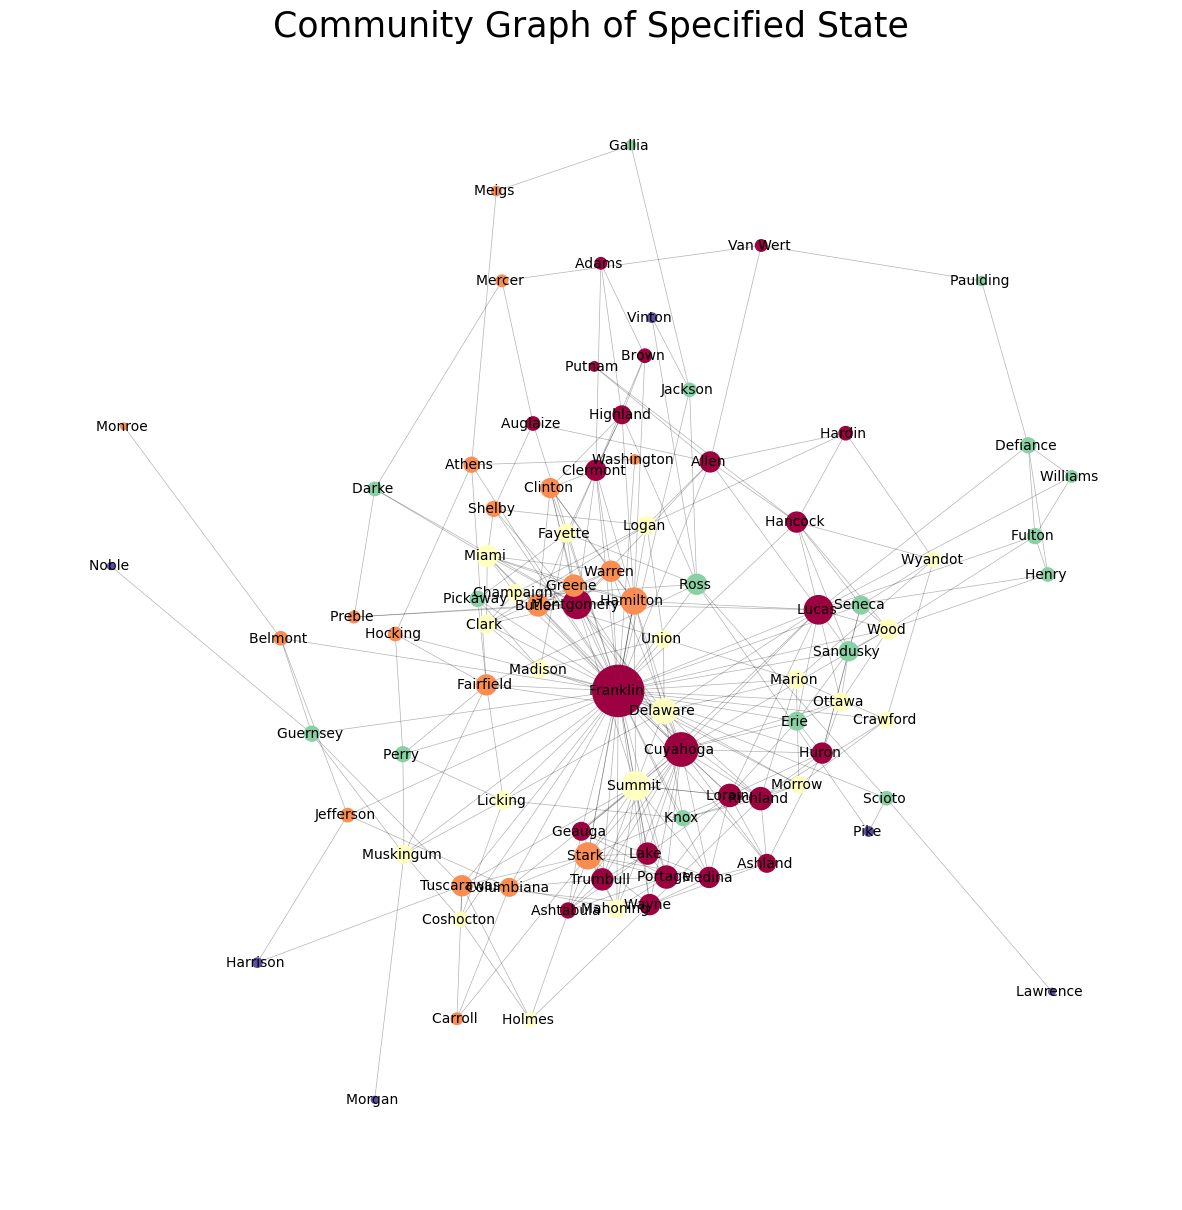

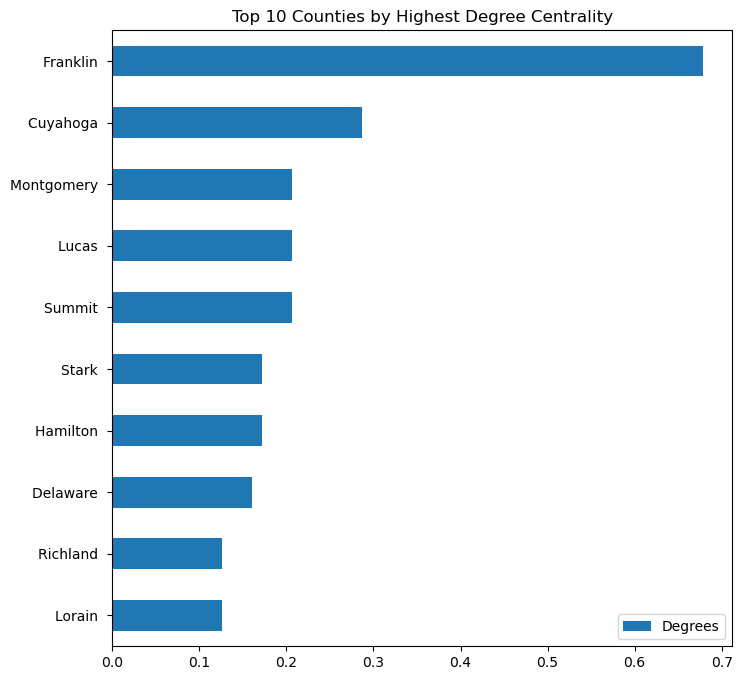

In [696]:
def CreateGraph(StateEdgeList, StateNodeList):

    # Generate the graph as an undirected graph
    G = nx.from_pandas_edgelist(StateEdgeList, source='OriginCountyName', target='TargetCountyName', edge_attr='ReturnNum')

    # Use CDLib's Louvain algorithm for community detection
    communities = algorithms.louvain(G)
    community_mapping = {node: i for i, community in enumerate(communities.communities) for node in community}
    
    # Create a spring layout for the entire graph
    pos = nx.spring_layout(G, seed=42, k=0.3)

    # Calculate degree centrality for node sizes
    degree_centrality = nx.degree_centrality(G)
    node_sizes = [degree_centrality[node] * 2000 for node in G.nodes()]
    
    # Color nodes by community
    cmap = cm.get_cmap('Spectral', max(community_mapping.values()) + 1)
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        cmap=cmap,
        node_color=list(community_mapping.values())
    )

    # Draw the network edges, labels, and show our graph
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title('Community Graph of Specified State', fontsize=25)
    plt.axis("off")
    plt.show()

    # Create a dataframe of degree centralities for our bar chart
    DegreeCentralityDict = dict(nx.degree_centrality(G))
    DegreeCentralityDf = pd.DataFrame(DegreeCentralityDict, index=[0]).T
    DegreeCentralityDf.columns = ['Degrees']
    DegreeCentralityDf.sort_values('Degrees', inplace=True, ascending=False)

    # Give the bar chart a title and output it
    title = 'Top 10 Counties by Highest Degree Centrality'
    _ = DegreeCentralityDf[0:10].plot.barh(title=title, figsize=(8, 8))
    plt.gca().invert_yaxis()

# Usage
CreateGraph(StateEdgeList, StateNodeList)

# Conclusion:

Some to-do's after this:
* Investigate longer distance moves (from one county in a state, to another county in a different state)
* Translate this notebook into an R Markdown file